### Data load & Preprocessing

In [1]:
import pandas as pd

train_df = pd.read_csv('./train.csv') 
test_df = pd.read_csv('./test.csv')
build_df = pd.read_csv('./building_info.csv')

# print(train_df.head())
# print('\n')
# print(test_df.head())
# print('\n')
# print(build_df.head())

In [2]:
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [3]:
train_df.columns = ['num_date_time', 'build_num','datetime','temperature','precipitation','wind_speed',
                    'humidity','sunlight','solar_power','electric_power_cousumption']
test_df.columns = ['num_date_time', 'build_num','datetime','temperature','precipitation','wind_speed',
                   'humidity']
build_df.columns = ['build_num','build_type','gross_area','cooling_area',
                    'solar_capacity','ess_capacity','pcs_capacity']
# delete unused columns
train_df.drop(columns = ['sunlight', 'solar_power'],inplace = True)

In [4]:
# building
kor_type = build_df['build_type'].unique()
print(kor_type)
type_list = ['etc','public','university','data_center','department_store','hospital',
             'commercial','aptartment','lab','knowledge_industry_complex','mart','hotel']
for i in range(len(kor_type)):
    idx = build_df[build_df['build_type'] == kor_type[i]].index
    build_df['build_type'].iloc[idx] = type_list[i]
    
# '-' = 태양광, ess, pcs 관련 시설 설치x => 0처리 (날리면 안됨)
tmp = build_df['solar_capacity'][0]
build_df['solar_capacity'].replace(tmp,0,inplace = True)
build_df['ess_capacity'].replace(tmp,0,inplace = True)
build_df['pcs_capacity'].replace(tmp,0,inplace = True)
build_df = build_df.astype(
    {
        'solar_capacity' : 'float64',
        'ess_capacity' : 'float64',
        'pcs_capacity' : 'float64'
    }
)

# 건물 정보와 시공간 정보 결합
train_df = pd.merge(train_df,build_df)
test_df = pd.merge(test_df,build_df)

['건물기타' '공공' '대학교' '데이터센터' '백화점및아울렛' '병원' '상용' '아파트' '연구소' '지식산업센터' '할인마트'
 '호텔및리조트']


/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## pre-processing

### date processing

In [5]:
# datetime column: str -> datetime
# %pip install pytimekr
from datetime import datetime
from pytimekr import pytimekr

train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

# 공휴일 여부
# 2022년 한국 공휴일
holidays_2022 = pytimekr.holidays(2022)
# 'is_holiday' 열 생성
def is_weekend(date):
    return date.weekday() >= 5  # 5 이상인 경우 (5: 토요일, 6: 일요일)
def is_holiday(date, holidays):
    return date in holidays
def calculate_is_holiday(row):
    is_weekend_flag = is_weekend(row['datetime'])
    is_holiday_flag = is_holiday(row['datetime'], holidays_2022)
    return is_weekend_flag or is_holiday_flag
train_df['is_holiday'] = train_df.apply(calculate_is_holiday, axis=1)
test_df['is_holiday'] = test_df.apply(calculate_is_holiday, axis=1)

# separate year - month - day - hour - weekday
# train_df['year'] = train_df['datetime'].dt.year -- all same 2022
train_df['month'] = train_df['datetime'].dt.month
train_df['day'] = train_df['datetime'].dt.day
train_df['hour'] = train_df['datetime'].dt.hour
train_df['weekday'] = train_df['datetime'].dt.weekday
# test_df['year'] = test_df['datetime'].dt.year
test_df['month'] = test_df['datetime'].dt.month
test_df['day'] = test_df['datetime'].dt.day
test_df['hour'] = test_df['datetime'].dt.hour
test_df['weekday'] = test_df['datetime'].dt.weekday

train_df.drop(columns = ['datetime'],inplace = True)
test_df.drop(columns = ['datetime'],inplace = True)

print(train_df.head())

   num_date_time  build_num  temperature  precipitation  wind_speed  humidity  \
0  1_20220601 00          1         18.6            NaN         0.9      42.0   
1  1_20220601 01          1         18.0            NaN         1.1      45.0   
2  1_20220601 02          1         17.7            NaN         1.5      45.0   
3  1_20220601 03          1         16.7            NaN         1.4      48.0   
4  1_20220601 04          1         18.4            NaN         2.8      43.0   

   electric_power_cousumption build_type  gross_area  cooling_area  \
0                     1085.28        etc    110634.0       39570.0   
1                     1047.36        etc    110634.0       39570.0   
2                      974.88        etc    110634.0       39570.0   
3                      953.76        etc    110634.0       39570.0   
4                      986.40        etc    110634.0       39570.0   

   solar_capacity  ess_capacity  pcs_capacity  is_holiday  month  day  hour  \
0            

### weather processing

In [6]:
# 불쾌지수
# 1.8x기온–0.55x(1–습도)x(1.8x기온–26)+32
train_df['discomfort_index'] = 1.8 * train_df['temperature'] - 0.55*(1-train_df['humidity'])*(1.8* train_df['temperature']-26 )+32
test_df['discomfort_index'] = 1.8 * test_df['temperature'] - 0.55*(1-test_df['humidity'])*(1.8* test_df['temperature']-26 )+32

# 기온-습도 조합
train_df['temp_humidity_combo'] = train_df['temperature'] * (1 - train_df['humidity'])
test_df['temp_humidity_combo'] = test_df['temperature'] * (1 - test_df['humidity'])

# 체감온도
# 13.12 + 0.6215*기온 - 11.37*풍속^0.16 +0.3965^0.16*기온 (풍속 단위 = km/h 이므로 현재 데이터에선 추가로 *3.6 변환 필요)
train_df['wind_chill'] = 13.12 + 0.6215*train_df['temperature'] - 11.37*(train_df['wind_speed'] * 3.6)**(0.16) + (0.3965)*train_df['temperature']*(train_df['wind_speed'] * 3.6)**(0.16)
test_df['wind_chill'] = 13.12 + 0.6215*test_df['temperature'] - 11.37*(test_df['wind_speed'] * 3.6)**(0.16) + (0.3965)*test_df['temperature']*(test_df['wind_speed'] * 3.6)**(0.16)

# # 강수여부 - categorical
# train_df['rainy_day'] = train_df['precipitation'] > 0
# test_df['rainy_day'] = test_df['precipitation'] > 0

# # 강수량의 종류 - categorical
# def categorize_rain(amount):
#     if amount == 0:
#         return 'no_rain'
#     elif amount < 5:
#         return 'light_rain'
#     else:
#         return 'heavy_rain'
# train_df['rain_type'] = train_df['precipitation'].apply(categorize_rain)
# test_df['rain_type'] = test_df['precipitation'].apply(categorize_rain)

### electricity usage pattern

In [7]:
# 시간대별 전력 소비량
hourly_electricity_usage = train_df.groupby('hour')['electric_power_cousumption'].mean().reset_index()
hourly_electricity_usage.rename(columns={'electric_power_cousumption': 'hourly_electricity_usage'}, inplace=True)
train_df = pd.merge(train_df, hourly_electricity_usage, on='hour', how='left')
test_df = pd.merge(test_df, hourly_electricity_usage, on='hour', how='left')

# # 전력 소비 시간대 - categorical
# train_df['electricity_usage_hour'] = train_df['hour'].apply(lambda x: 'peak' if 8 <= x <= 22 else 'off-peak')
# test_df['electricity_usage_hour'] = test_df['hour'].apply(lambda x: 'peak' if 8 <= x <= 22 else 'off-peak')

# # 전력 사용 타입 - categorical
# train_df['electricity_usage_type'] = train_df.apply(lambda row: f"{row['build_type']}_{row['hour']}", axis=1)
# test_df['electricity_usage_type'] = test_df.apply(lambda row: f"{row['build_type']}_{row['hour']}", axis=1)

In [8]:
print(train_df.columns)
print(test_df.columns)
train_df.head()

Index(['num_date_time', 'build_num', 'temperature', 'precipitation',
       'wind_speed', 'humidity', 'electric_power_cousumption', 'build_type',
       'gross_area', 'cooling_area', 'solar_capacity', 'ess_capacity',
       'pcs_capacity', 'is_holiday', 'month', 'day', 'hour', 'weekday',
       'discomfort_index', 'temp_humidity_combo', 'wind_chill',
       'hourly_electricity_usage'],
      dtype='object')
Index(['num_date_time', 'build_num', 'temperature', 'precipitation',
       'wind_speed', 'humidity', 'build_type', 'gross_area', 'cooling_area',
       'solar_capacity', 'ess_capacity', 'pcs_capacity', 'is_holiday', 'month',
       'day', 'hour', 'weekday', 'discomfort_index', 'temp_humidity_combo',
       'wind_chill', 'hourly_electricity_usage'],
      dtype='object')


,num_date_time,build_num,temperature,precipitation,wind_speed,humidity,electric_power_cousumption,build_type,gross_area,cooling_area,...,pcs_capacity,is_holiday,month,day,hour,weekday,discomfort_index,temp_humidity_combo,wind_chill,hourly_electricity_usage
0,1_20220601 00,1,18.6,NaN,0.9,42.0,1085.28,etc,110634.0,39570.0,...,0.0,False,6,1,0,2,234.154,-762.6,19.858037,1832.909812
1,1_20220601 01,1,18.0,NaN,1.1,45.0,1047.36,etc,110634.0,39570.0,...,0.0,False,6,1,1,2,219.280,-792.0,19.031307,1785.853802
2,1_20220601 02,1,17.7,NaN,1.5,45.0,974.88,etc,110634.0,39570.0,...,0.0,False,6,1,2,2,205.672,-778.8,18.420654,1754.573766
3,1_20220601 03,1,16.7,NaN,1.4,48.0,953.76,etc,110634.0,39570.0,...,0.0,False,6,1,3,2,167.011,-784.9,17.348120,1735.193839
4,1_20220601 04,1,18.4,NaN,2.8,43.0,986.40,etc,110634.0,39570.0,...,0.0,False,6,1,4,2,229.592,-772.8,18.658787,1737.142635


## precipitation EDA

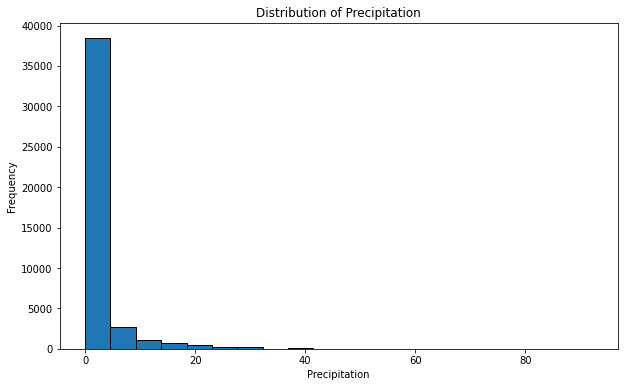

In [9]:
# 'precipitation' 열의 분포 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(train_df['precipitation'], bins=20, edgecolor='black')
plt.title('Distribution of Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.show()

# 0 에 다 몰려있음. 0 취급해도 될 듯

### null to zero

In [10]:
train_df.isnull().sum()

num_date_time                      0
build_num                          0
temperature                        0
precipitation                 160069
wind_speed                        19
humidity                           9
electric_power_cousumption         0
build_type                         0
gross_area                         0
cooling_area                       0
solar_capacity                     0
ess_capacity                       0
pcs_capacity                       0
is_holiday                         0
month                              0
day                                0
hour                               0
weekday                            0
discomfort_index                   9
temp_humidity_combo                9
wind_chill                        19
hourly_electricity_usage           0
dtype: int64

In [11]:
# Null 값 제거
train_df.fillna(0, inplace=True)
# train_df.isnull().sum()

In [12]:
# # categorical - one hot encoding
# # rf feature importance 계산 용

# train_df = pd.get_dummies(
#     data = train_df, 
#     columns = [
#         'build_type'
#     ], 
#     drop_first = True,
#     dtype = int
# )
# test_df = pd.get_dummies(
#     data = test_df, 
#     columns = [
#         'build_type'
#     ], 
#     drop_first=True,
#     dtype = int
# )

# train_df.head()

,num_date_time,build_num,temperature,precipitation,wind_speed,humidity,electric_power_cousumption,gross_area,cooling_area,solar_capacity,...,build_type_data_center,build_type_department_store,build_type_etc,build_type_hospital,build_type_hotel,build_type_knowledge_industry_complex,build_type_lab,build_type_mart,build_type_public,build_type_university
0,1_20220601 00,1,18.6,0.0,0.9,42.0,1085.28,110634.0,39570.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,1_20220601 01,1,18.0,0.0,1.1,45.0,1047.36,110634.0,39570.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,1_20220601 02,1,17.7,0.0,1.5,45.0,974.88,110634.0,39570.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,1_20220601 03,1,16.7,0.0,1.4,48.0,953.76,110634.0,39570.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,1_20220601 04,1,18.4,0.0,2.8,43.0,986.40,110634.0,39570.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [12]:
# categorical - astype category

train_df['build_type'] = train_df['build_type'].astype('category')
test_df['build_type'] = test_df['build_type'].astype('category')

train_df.head()

,num_date_time,build_num,temperature,precipitation,wind_speed,humidity,electric_power_cousumption,build_type,gross_area,cooling_area,...,pcs_capacity,is_holiday,month,day,hour,weekday,discomfort_index,temp_humidity_combo,wind_chill,hourly_electricity_usage
0,1_20220601 00,1,18.6,0.0,0.9,42.0,1085.28,etc,110634.0,39570.0,...,0.0,False,6,1,0,2,234.154,-762.6,19.858037,1832.909812
1,1_20220601 01,1,18.0,0.0,1.1,45.0,1047.36,etc,110634.0,39570.0,...,0.0,False,6,1,1,2,219.280,-792.0,19.031307,1785.853802
2,1_20220601 02,1,17.7,0.0,1.5,45.0,974.88,etc,110634.0,39570.0,...,0.0,False,6,1,2,2,205.672,-778.8,18.420654,1754.573766
3,1_20220601 03,1,16.7,0.0,1.4,48.0,953.76,etc,110634.0,39570.0,...,0.0,False,6,1,3,2,167.011,-784.9,17.348120,1735.193839
4,1_20220601 04,1,18.4,0.0,2.8,43.0,986.40,etc,110634.0,39570.0,...,0.0,False,6,1,4,2,229.592,-772.8,18.658787,1737.142635


## Feature Importance

[1.03466617e-01 1.26226660e-03 9.90431140e-05 5.65596624e-04
 5.41738280e-04 2.58238408e-01 2.73775844e-01 7.49414117e-02
 4.62287155e-04 5.06455351e-04 2.19658033e-02 1.77738818e-03
 2.09735657e-03 1.07440500e-02 3.47639371e-03 1.11572174e-02
 1.29194350e-03 1.38687729e-03 6.52170457e-02 5.79871837e-04
 9.25732286e-02 6.21600613e-03 2.26852964e-03 1.29222154e-02
 6.06125100e-04 1.18561745e-03 1.93572186e-02 1.17325921e-04
 6.71212968e-04 3.05289048e-02]
important features: [6, 5, 0, 20, 7, 18, 29, 10, 26, 23, 15, 13, 21, 14, 22, 12, 11, 17, 16, 1, 25, 28, 24, 19, 3, 4, 9, 8, 27, 2]


<Figure size 864x2304 with 0 Axes>

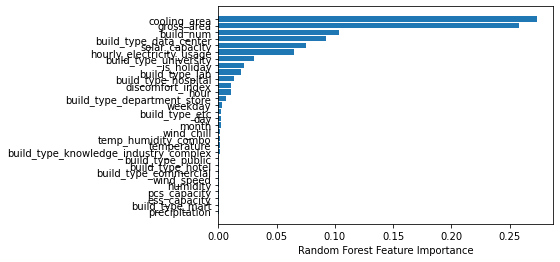

<Figure size 864x2304 with 0 Axes>

In [13]:
# from sklearn.ensemble import RandomForestRegressor
# from matplotlib import pyplot as plt

# y = train_df['electric_power_cousumption']
# X = train_df.drop(
#     [
#         'num_date_time',
#         'electric_power_cousumption'
#     ], 
#     axis=1
# )

# rf = RandomForestRegressor(n_estimators=100)
# rf.fit(X, y)

# print(rf.feature_importances_)

# important_features_dict = {}
# for idx, val in enumerate(rf.feature_importances_):
#     important_features_dict[idx] = val

# important_features_list = sorted(important_features_dict,
#                                  key=important_features_dict.get,
#                                  reverse=True)

# print(f'important features: {important_features_list[:]}')

# sorted_idx = rf.feature_importances_.argsort()
# plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
# plt.xlabel("Random Forest Feature Importance")
# plt.figure(figsize=(12,32))

# LightGBM

In [13]:
# %pip install lightgbm
!brew install libomp

import os
os.environ["DYLD_LIBRARY_PATH"] = "/usr/local/opt/libomp/lib:$DYLD_LIBRARY_PATH"
# print(train_df.dtypes)

To reinstall 16.0.6, run:
  brew reinstall libomp


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1847
[LightGBM] [Info] Number of data points in the train set: 163200, number of used features: 20
[LightGBM] [Info] Start training from score 2454.992727
Mean squared error:  20934.63316913893
R2 score:  0.9964133802043666
5.623965336772558


<AxesSubplot:xlabel='label', ylabel='predict'>

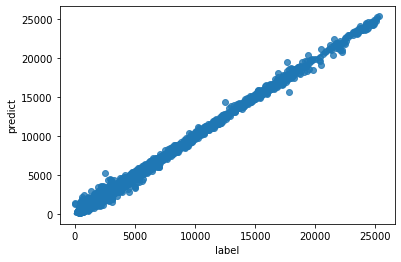

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns

y = train_df['electric_power_cousumption']
X = train_df.drop(
    [
        'num_date_time',
        'electric_power_cousumption'
    ], 
    axis=1
)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=321)

train_ds = lgb.Dataset(X_train, label = y_train) 
test_ds = lgb.Dataset(X_valid, label = y_valid) 

params = {
    'learning_rate': 0.2, 
    'max_depth': -1, #16, 
#     'num_leaves': 144, 
#     'boosting': 'gbdt', 
#     'num_iterations': 1000,
#     'early_stopping_rounds': 50,
    'objective': 'regression', 
    'metric': 'mse', 
#     'is_training_metric': True, 
#     'feature_fraction': 0.9, 
#     'bagging_fraction': 0.7, 
#     'bagging_freq': 5, 
    'seed':321
} 
# one-hot-encoding : building_type
# mse 22319 
# r2 0.9962

# astype('category')
# mse 21658
# r2 0.9963
# smape 5.66

# column 추가 - date, weather, electricity consume pattern
# mse 20934
# r2 0.9964
# smape 5.6240


model = lgb.train(params, train_ds, 1000, test_ds)

predict_train = model.predict(X_train)
predict_test = model.predict(X_valid)


# 에러 확인
mse = mean_squared_error(y_valid, predict_test)
r2 = r2_score(y_valid, predict_test)
print('Mean squared error: ', mse)
print('R2 score: ', r2)
final_result = pd.concat(
    [y_valid.reset_index(drop=True), pd.DataFrame(predict_test)], 
    axis = 1
)

# 테스트 데이터에 대한 예측 수행
def smape(y_true, y_pred):
    num = np.abs((y_true) - (y_pred))
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(num / denom) * 100 

test_pred = model.predict(X_valid, num_iteration=model.best_iteration)
print(smape(y_valid, test_pred))

# fit 결과 확인
final_result.columns = ['label','predict']
sns.regplot(x = 'label', y = 'predict', data = final_result)

In [15]:
test_df.head()

,num_date_time,build_num,temperature,precipitation,wind_speed,humidity,build_type,gross_area,cooling_area,solar_capacity,...,pcs_capacity,is_holiday,month,day,hour,weekday,discomfort_index,temp_humidity_combo,wind_chill,hourly_electricity_usage
0,1_20220825 00,1,23.5,0.0,2.2,72,etc,110634.0,39570.0,0.0,...,0.0,False,8,25,0,3,710.815,-1668.5,24.867486,1832.909812
1,1_20220825 01,1,23.0,0.0,0.9,72,etc,110634.0,39570.0,0.0,...,0.0,False,8,25,1,3,674.770,-1633.0,24.698272,1785.853802
2,1_20220825 02,1,22.7,0.0,1.5,75,etc,110634.0,39570.0,0.0,...,0.0,False,8,25,2,3,677.662,-1679.8,24.124701,1754.573766
3,1_20220825 03,1,22.1,0.0,1.3,78,etc,110634.0,39570.0,0.0,...,0.0,False,8,25,3,3,655.363,-1701.7,23.517516,1735.193839
4,1_20220825 04,1,21.8,0.0,1.0,77,etc,110634.0,39570.0,0.0,...,0.0,False,8,25,4,3,624.672,-1656.8,23.322268,1737.142635


In [16]:
# 결과 저장

test_X = test_df.drop('num_date_time', axis=1)
test_pred = model.predict(test_X, num_iteration=model.best_iteration)

submission = pd.DataFrame({'num_date_time': test_df['num_date_time'], 'answer': test_pred})
submission.to_csv('submission.csv', index=False)